In [28]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
from tqdm import tqdm
import cv2
from keras.models import load_model
import keras
from keras import backend as K
import matplotlib.pyplot as plt

In [29]:
def iou_score(y_pred, y_true, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true, -1) + K.sum(y_pred, -1) - intersection
    iou = (intersection + smooth)/(union + smooth)
    return iou

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)
custom_objects = {"dice_coef_loss": dice_coef_loss, 'iou_score': iou_score}

with keras.saving.custom_object_scope(custom_objects):
    model = load_model("r2u_attention_80e.h5")

In [3]:
with keras.saving.custom_object_scope(custom_objects):
    catheter_model = load_model("catheter_detect.h5",safe_mode=False)

In [4]:
def match(img, pred_img):
    match_img = pred_img*img
    return match_img

# function to average color
def average(img, i, j, r):
  sum = 0
  for x in range(i - r, i + r + 1):
    for y in range(j -r, j + r + 1):
      sum += img[x][y]
  return sum/((2*r + 1)**2)

# function to match the segmentation back to the origin image, but we just get a square area
def square_match(img, pred_img, target):
  # get top, right, bottom, left boundary

  top_flat = 0
  top_index = 512
  for i in range(0, 510):
    for j in range(0, 510):
      if average(pred_img, i, j, 2) > 0.7:
        top_flat = 1
        top_index = max(0, i - 10)
        break
    if top_flat == 1:
      break

  right_flat = 0
  right_index = 0
  for j in reversed(range(0, 510)):
    for i in range(0, 510):
      if average(pred_img, i, j, 2) > 0.7:
        right_flat = 1
        right_index = min(j + 10, 512)
        break
    if right_flat == 1:
      break

  bottom_flat = 0
  bottom_index = 0
  for i in reversed(range(0, 510)):
    for j in range(0, 510):
      if average(pred_img, i, j, 2) > 0.7:
        bottom_flat = 1
        bottom_index = min(512, i + 10)
        break
    if bottom_flat == 1:
      break

  left_flat = 0
  left_index = 512
  for j in range(0, 510):
    for i in range(0, 510):
      if average(pred_img, i, j, 2) > 0.7:
        left_flat = 1
        left_index = max(0, j - 10)
        break
    if left_flat == 1:
      break

  if target == "full":
    for i in range(512):
      for j in range(512):
        if i < top_index or i > bottom_index or j < left_index or j > right_index:
          img[i][j] = 0

  if target == "crop":
    if left_index == 512 and top_index == 512 and right_index == 0 and bottom_index == 0:
      return 0
    else:
      return img[top_index:bottom_index, left_index:right_index]

  return img

def predict_one_image(img, model):
  resized_img = cv2.resize(img, (512, 512))
  X = np.reshape(resized_img, (1, resized_img.shape[0], resized_img.shape[1], 1))
  normalized_X = X/255
  normalized_X = np.rollaxis(normalized_X, 3, 1)
  pred_y = model.predict(normalized_X, verbose=0)
  pred_y[pred_y > 0.5] = 1
  pred_y[pred_y != 1] = 0
  pred_img = np.reshape(pred_y[0]*255, (512, 512))
  match_img = pred_img*resized_img
  return pred_img, match_img

def remove_catheter(image):
    vessel_img, _ = predict_one_image(image, model)
    catheter_img, _ = predict_one_image(image, catheter_model)
    subtract_image = vessel_img - catheter_img
    _, binary = cv2.threshold(subtract_image, 50, 255, cv2.THRESH_BINARY)
    binary = binary.astype(np.uint8)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = find_largest_contour(contours)
    mask = np.zeros_like(binary)
    cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
    vessel_img = cv2.bitwise_and(subtract_image, subtract_image, mask=mask)
    resized_img = cv2.resize(img, (512, 512))
    return vessel_img/255., resized_img*vessel_img/255.

def get_vessel(image):
    vessel_img, _ = predict_one_image(image, model)
    subtract_image = vessel_img 
    resized_img = cv2.resize(img, (512, 512))
    return vessel_img/255., resized_img*vessel_img/255.

def find_largest_contour(contours):
    max_contour = None
    max_area = 0
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            max_contour = contour
    return max_contour

def neighbours(x,y,image):
    img = image
    x_1, y_1, x1, y1 = x-1, y-1, x+1, y+1
    return [ img[x_1][y], img[x_1][y1], img[x][y1], img[x1][y1],     # P2,P3,P4,P5
                img[x1][y], img[x1][y_1], img[x][y_1], img[x_1][y_1] ]    # P6,P7,P8,P9

def transitions(neighbours):
    n = neighbours + neighbours[0:1]      # P2, P3, ... , P8, P9, P2
    return sum( (n1, n2) == (0, 1) for n1, n2 in zip(n, n[1:]) )  # (P2,P3), (P3,P4), ... , (P8,P9), (P9,P2)

def zhangSuen(image):
    Image_Thinned = image.copy()  # deepcopy to protect the original image
    changing1 = changing2 = 1        #  the points to be removed (set as 0)
    while changing1 or changing2:   #  iterates until no further changes occur in the image
        # Step 1
        changing1 = []
        rows, columns = Image_Thinned.shape               # x for rows, y for columns
        for x in range(1, rows - 1):                     # No. of  rows
            for y in range(1, columns - 1):            # No. of columns
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1     and    # Condition 0: Point P1 in the object regions
                    2 <= sum(n) <= 6   and    # Condition 1: 2<= N(P1) <= 6
                    transitions(n) == 1 and    # Condition 2: S(P1)=1
                    P2 * P4 * P6 == 0  and    # Condition 3
                    P4 * P6 * P8 == 0):         # Condition 4
                    changing1.append((x,y))
        for x, y in changing1:
            Image_Thinned[x][y] = 0
        # Step 2
        changing2 = []
        for x in range(1, rows - 1):
            for y in range(1, columns - 1):
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1   and        # Condition 0
                    2 <= sum(n) <= 6  and       # Condition 1
                    transitions(n) == 1 and      # Condition 2
                    P2 * P4 * P8 == 0 and       # Condition 3
                    P2 * P6 * P8 == 0):            # Condition 4
                    changing2.append((x,y))
        for x, y in changing2:
            Image_Thinned[x][y] = 0
    return Image_Thinned

def distance(x1,y1,x2,y2):
  return np.sqrt((x1-x2)**2 + (y1-y2)**2)

def min_distance(x,y, vector, limit):
  if limit > 0:
    d = [distance(x, y, vector[i][0],vector[i][1]) for i in range(limit)]
    d.sort()
    return d[0]
  return 1000

def vectorize_one_image_using_center_line(img):
  vector = np.zeros((MAX_VECTORS, 3), dtype=np.float32)
  STEP = 5
  resized_img = cv2.resize(img, (512, 512))
  pred_img, match_img = get_vessel(img)

  centerline = zhangSuen(pred_img.astype(int))

  all_zeros = np.all(pred_img == 0)
  if all_zeros:
    return np.zeros((MAX_VECTORS, 3)), None
  img_with_rectangles = cv2.cvtColor(match_img, cv2.COLOR_GRAY2BGR)
  centerline_with_rect = cv2.cvtColor(centerline.astype(np.float32)*255, cv2.COLOR_GRAY2BGR)
  index = 0
  WS12 = WINDOW_SIZE//2

  for y in range(0, IMAGE_HEIGHT, STEP):
      for x in range(0, IMAGE_WIDTH, STEP):
          window = centerline[y:y + STEP, x:x + STEP]
          x_arr, y_arr = np.where(window==1)
          if len(x_arr) > 2:
            # calculate the center point of window
            x_w = int(x_arr.mean()) + x
            y_w = int(y_arr.mean()) + y

            # get closest window from x_w, y_w
            m_distance = min_distance(x_w, y_w, vector, index)
            # check overlap among window
            if m_distance >  WS12 * 1.5:
              window = pred_img[y_w - WS12 : y_w + WS12, x_w - WS12 : x_w + WS12]
              upper_left = (x_w - WS12, y_w - WS12)
              lower_right = (x_w + WS12, y_w + WS12)
              # disable area that we already used
              centerline[upper_left[1]:lower_right[1]+1,upper_left[0]:lower_right[0]+1] = 0

              cv2.rectangle(img_with_rectangles, upper_left, lower_right, (0, 255, 0), 1)
              cv2.rectangle(centerline_with_rect, upper_left, lower_right, (0, 255, 0), 1)

              average_color = np.sum(window)
              vector[index] = np.array([x_w, y_w, average_color])
              index+=1
              if index>=MAX_VECTORS:
                break
      if index>=MAX_VECTORS:
        break
  return vector, img_with_rectangles, centerline_with_rect

In [5]:
# def vectorize_one_image_using_center_line(img):
#     vector = np.zeros((MAX_VECTORS, 3), dtype=np.float32)
#     STEP = 5
#     RESIZE_DIM = (512, 512)
#     resized_img = cv2.resize(img, RESIZE_DIM)
#     pred_img, match_img = get_vessel(img)

#     centerline = zhangSuen(pred_img.astype(int))

#     if np.all(pred_img == 0):
#         return vector, None

#     img_with_rectangles = cv2.cvtColor(match_img, cv2.COLOR_GRAY2BGR)
#     centerline_with_rect = cv2.cvtColor(centerline.astype(np.float32) * 255, cv2.COLOR_GRAY2BGR)
#     index = 0
#     WS12 = WINDOW_SIZE // 2
#     IMAGE_DIM = (IMAGE_HEIGHT, IMAGE_WIDTH)

#     for y in range(0, IMAGE_DIM[0], STEP):
#         for x in range(0, IMAGE_DIM[1], STEP):
#             window = centerline[y:y + STEP, x:x + STEP]
#             if np.count_nonzero(window) > 2:
#                 y_arr, x_arr = np.where(window == 1)
#                 x_w = int(x_arr.mean()) + x
#                 y_w = int(y_arr.mean()) + y

#                 if min_distance(x_w, y_w, vector, index) > WS12 * 1.5:
#                     upper_left = (max(0, x_w - WS12), max(0, y_w - WS12))
#                     lower_right = (min(IMAGE_WIDTH, x_w + WS12), min(IMAGE_HEIGHT, y_w + WS12))
                    
#                     if (lower_right[0] - upper_left[0]) <= 0 or (lower_right[1] - upper_left[1]) <= 0:
#                         continue

#                     window = pred_img[upper_left[1]:lower_right[1], upper_left[0]:lower_right[0]]
#                     centerline[upper_left[1]:lower_right[1], upper_left[0]:lower_right[0]] = 0

#                     cv2.rectangle(img_with_rectangles, upper_left, lower_right, (0, 255, 0), 1)
#                     cv2.rectangle(centerline_with_rect, upper_left, lower_right, (0, 255, 0), 1)

#                     average_color = window.sum()
#                     vector[index] = [x_w, y_w, average_color]
#                     index += 1

#                     if index >= MAX_VECTORS:
#                         return vector, img_with_rectangles

#     return vector, img_with_rectangles, centerline_with_rect

In [6]:
df_train = pd.read_csv('train_labels.csv')
df_val = pd.read_csv('test_labels.csv')

df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,14_024_2_0042.bmp,800,800,Stenosis,235,156,282,192
1,14_031_4_0031.bmp,800,800,Stenosis,419,319,446,349
2,14_046_5_0066.bmp,1000,1000,Stenosis,679,307,699,336
3,14_010_6_0035.bmp,512,512,Stenosis,94,244,126,286
4,14_014_1_0015.bmp,512,512,Stenosis,163,118,203,151


In [7]:
filenames = df_train.filename.values

In [8]:
# image = cv2.imread("data/14_024_2_0042.bmp", 0)
# cv2.rectangle(image, (235, 156), (282,192), (0, 255, 0), 1)
# plt.imshow(image)
# plt.show()

In [9]:
# vector, img_with_rectangles, centerline_with_rect = vectorize_one_image_using_center_line(image)

In [10]:
WINDOW_SIZE = 20
IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512
MAX_VECTORS = 40

In [11]:
def adjust_boxes(row):
    width_scale = 512 / row['width']
    height_scale = 512 / row['height']
    
    row['xmin'] = int(row['xmin'] * width_scale)
    row['ymin'] = int(row['ymin'] * height_scale)
    row['xmax'] = int(row['xmax'] * width_scale)
    row['ymax'] = int(row['ymax'] * height_scale)
    
    return row

In [12]:
df_train = pd.read_csv('train_labels.csv')
df_train = df_train.apply(adjust_boxes, axis=1)
df_train = df_train[['filename', 'xmin', 'ymin', 'xmax', 'ymax']]

In [13]:
def is_window_overlap(x, y, window_size, box):
    xmin = x - window_size / 2
    ymin = y - window_size / 2
    xmax = x + window_size / 2
    ymax = y + window_size / 2
    
    box_xmin, box_ymin, box_xmax, box_ymax = box
    
    if (xmin < box_xmax and xmax > box_xmin and
        ymin < box_ymax and ymax > box_ymin):
        return 1
    else:
        return 0

In [35]:
import time
start = time.time()
skeletion = skeletonize(pred_img.astype(int))
print(time.time()-start)

0.012850761413574219


In [36]:
import time
start = time.time()
skeletion = zhangSuen(pred_img.astype(int))
print(time.time()-start)

6.071935653686523


In [17]:
from skimage.morphology import skeletonize

In [34]:
filenames = df_train.filename.values
vectors = np.zeros((len(filenames), 40, 3))
labels = np.zeros((len(filenames), 40))
boxes = df_train[['xmin', 'ymin', 'xmax', 'ymax']].values

for index, filename in tqdm(enumerate(filenames)):
    img = cv2.imread(os.path.join("data", filename), 0)
    resized_img = cv2.resize(img, (512, 512))
    pred_img, match_img = get_vessel(img)
    skeletion = skeletonize(pred_img.astype(int))
    vector, img_with_rectangles, centerline_with_rect = vectorize_one_image_using_center_line(img)
    label = []
    for v in vector:
        x, y, color = v
        label.append(is_window_overlap(x, y, WINDOW_SIZE//2, boxes[index]))
    vectors[index] = vector
    label = np.array(label)
    labels[index] = label
    break
#     np.save("label.npy", labels)
#     np.save("vector.npy", vectors)

0it [00:06, ?it/s]


In [19]:
labels = np.load("label.npy")
vectors = np.load("vector.npy")

In [20]:
vectors = vectors[:546]
labels = labels[:546]

In [21]:
num_labels = 40
num_classes_per_label = 2
feature_dim = 512
num_windows = 40
num_epochs = 20
learning_rate = 1e-3

In [22]:
import datetime
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

today = str(datetime.date.today())+".keras"
f1_modelcheckpoint_callback = ModelCheckpoint(
    today,
    monitor='loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

f1_early_stopping_callback = EarlyStopping(
    monitor='loss',
    patience=25,
    mode='min',
    restore_best_weights=True,
    verbose=1
)

In [41]:
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, units):
        super(AttentionLayer, self).__init__()
        self.units = units
        
    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='random_normal',
                                 trainable=True)
        self.V = self.add_weight(shape=(self.units, 1),
                                 initializer='random_normal',
                                 trainable=True)
        
    def call(self, inputs):
        score = tf.nn.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        attention_weights = tf.nn.softmax(tf.tensordot(score, self.V, axes=1), axis=1)
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector

class StenosisDetectionModel(tf.keras.Model):
    def __init__(self, num_labels):
        super(StenosisDetectionModel, self).__init__()
        self.num_labels = num_labels
        
        self.attention = AttentionLayer(64)
        self.batch_norm1 = tf.keras.layers.BatchNormalization()
        self.dense1 = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.dropout1 = tf.keras.layers.Dropout(0.5)
        self.batch_norm2 = tf.keras.layers.BatchNormalization()
        self.dense2 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.dropout2 = tf.keras.layers.Dropout(0.5)
        self.fc = tf.keras.layers.Dense(num_labels, activation='sigmoid')  
        
    def call(self, x):
        context_vector = self.attention(x)
        x = self.batch_norm1(context_vector)
        x = self.dense1(x)
        x = self.dropout1(x)
        x = self.batch_norm2(x)
        x = self.dense2(x)
        x = self.dropout2(x)
        output = self.fc(x)  
        return output

num_epochs = 50
learning_rate = 0.0001  

stenosis_model = StenosisDetectionModel(num_labels)
stenosis_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),  
                       loss='binary_crossentropy', 
                       metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [49]:
y_test = [0,0,1]
y_pred = [1,0,1]
np.where((y_test==y_pred))

(array([], dtype=int64),)

In [ ]:
def accuracy_sample(y_test, y_pred):
    count = 0
    for index in range(len(y_test)):
        if y_test[index]==y_pred[index]:
            count+=1
    return count/len(y_test)

def accuracy(y_test, y_pred):
    count = 0
    
    return count/len(y_test)

In [42]:
checkpoint_filepath = 'model_checkpoint.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True)

In [40]:
train_dataset = tf.data.Dataset.from_tensor_slices((vectors, labels))
train_dataset = train_dataset.shuffle(buffer_size=75).batch(32)

history = stenosis_model.fit(train_dataset, epochs=num_epochs, callbacks=[model_checkpoint_callback, early_stopping_callback])

Epoch 1/50
235/235 [==============================] - 2s 5ms/step - loss: 2.3135 - accuracy: 0.0121 - auc_1: 1.0000 - precision_1: 2.0143e-05 - recall_1: 1.0000
Epoch 2/50
235/235 [==============================] - 1s 5ms/step - loss: 1.6300 - accuracy: 0.0175 - auc_1: 0.0069 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 3/50
235/235 [==============================] - 1s 5ms/step - loss: 1.1959 - accuracy: 0.0186 - auc_1: 1.0842e-04 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 4/50
235/235 [==============================] - 1s 5ms/step - loss: 0.9620 - accuracy: 0.0192 - auc_1: 0.0032 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 5/50
235/235 [==============================] - 1s 5ms/step - loss: 0.8328 - accuracy: 0.0200 - auc_1: 0.0167 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 6/50
235/235 [==============================] - 1s 5ms/step - loss: 0.7641 - accuracy: 0.0176 - auc_1: 0.9794 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 7/50

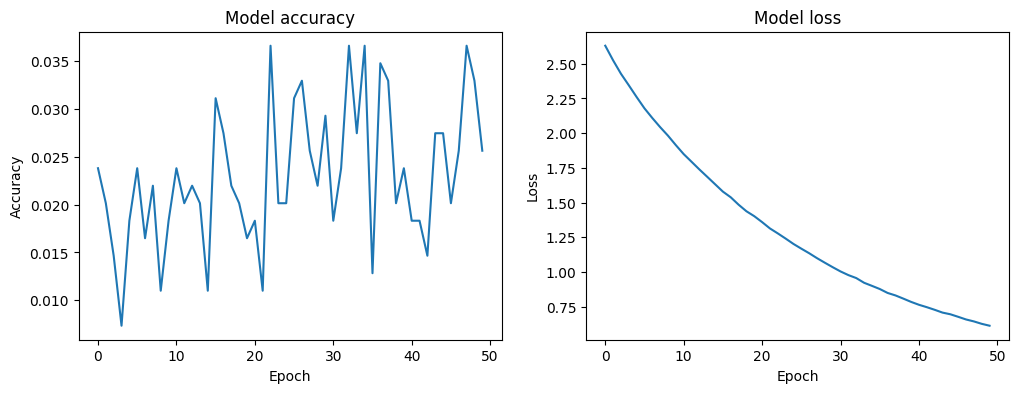

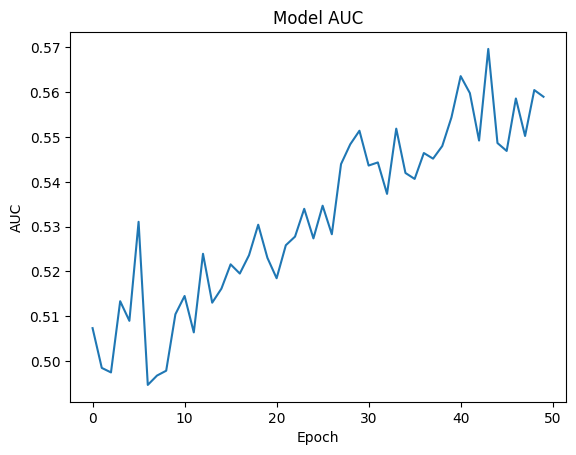

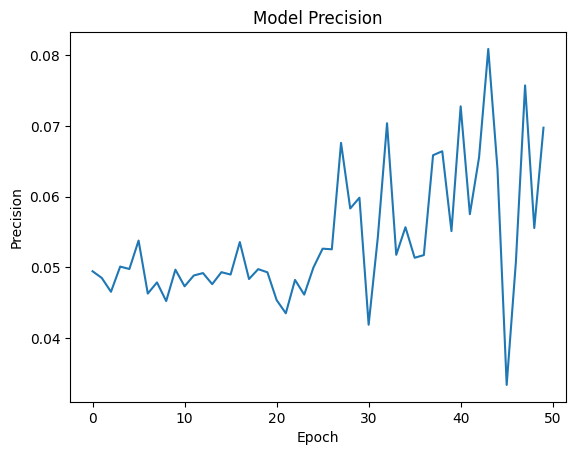

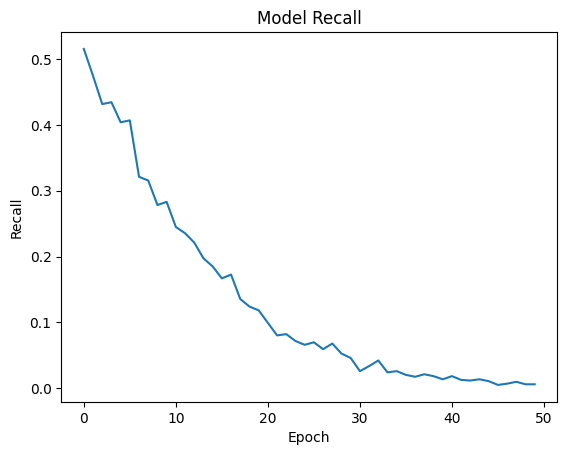

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.show()

# Plotting AUC
plt.plot(history.history['auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.show()

# Plotting Precision
plt.plot(history.history['precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.show()

# Plotting Recall
plt.plot(history.history['recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.show()

In [30]:
sigmoid_logits = tf.constant([1., -1., 0.])
softmax_logits = tf.stack([sigmoid_logits, tf.zeros_like(sigmoid_logits)],
                          axis=-1)
soft_binary_labels = tf.constant([1., 1., 0.])
soft_multiclass_labels = tf.stack(
    [soft_binary_labels, 1. - soft_binary_labels], axis=-1)
hard_labels = tf.constant([0, 0, 1])
tf.nn.sparse_softmax_cross_entropy_with_logits(
    labels=hard_labels, logits=softmax_logits).numpy()

tf.nn.softmax_cross_entropy_with_logits(
    labels=soft_multiclass_labels, logits=softmax_logits).numpy()

tf.nn.sigmoid_cross_entropy_with_logits(
    labels=soft_binary_labels, logits=sigmoid_logits).numpy()


array([0.3132617, 1.3132617, 0.6931472], dtype=float32)

In [31]:
soft_multiclass_labels

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)>

In [33]:
soft_binary_labels

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 1., 0.], dtype=float32)>

In [47]:
labels = tf.constant([1., 0.5, 0.])
logits = tf.constant([1.5, -0.1, -10.])
print(tf.nn.weighted_cross_entropy_with_logits(
    labels=labels, logits=logits, pos_weight=tf.constant(1.0)).numpy())

print(tf.nn.weighted_cross_entropy_with_logits(
    labels=labels, logits=logits, pos_weight=tf.constant(0.5)).numpy())


[2.0141329e-01 6.9439667e-01 4.5776367e-05]
[1.00706644e-01 5.08297503e-01 4.57763672e-05]
